In [2]:
!pip install prophet statsmodels scikit-learn pandas numpy matplotlib seaborn

IMPORTING NECESSARY LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce

In [6]:
df = pd.read_csv("/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")
df.head(5)

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,11/01/2023,10536,8347,223,14072,0,48.0
4,11/09/2021,820,612,0,1283,0,11.0


DATA CLEANING AND PROCESSING

In [7]:
df_clean = df.copy()

In [24]:
df_clean['Date'] = pd.to_datetime(df_clean['Date'], dayfirst=True, errors='coerce')
df_clean.head()

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,DayOfWeek
0,2019-07-01,15987,9962,407,21223,3715,0.0,Monday
1,2019-07-02,16895,10656,409,21715,3993,0.0,Tuesday
2,2019-07-03,16613,10658,427,22025,3638,0.0,Wednesday
3,2019-07-04,16604,10445,437,21868,3576,0.0,Thursday
4,2019-07-05,16040,10532,400,20697,2856,0.0,Friday


In [9]:
df_clean = df_clean.dropna(subset=['Date'])
df_clean = df_clean.drop_duplicates(subset='Date')
df_clean = df_clean.sort_values('Date').reset_index(drop=True)

In [10]:
num_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
for col in num_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

In [11]:
df_clean[num_cols] = df_clean[num_cols].interpolate(method='linear')
df_clean[num_cols] = df_clean[num_cols].fillna(method='bfill')
df_clean[num_cols] = df_clean[num_cols].fillna(method='ffill')

/tmp/ipython-input-106494763.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean[num_cols] = df_clean[num_cols].fillna(method='bfill')
/tmp/ipython-input-106494763.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean[num_cols] = df_clean[num_cols].fillna(method='ffill')


In [12]:
df_clean = df_clean.set_index('Date').asfreq('D')
df_clean[num_cols] = df_clean[num_cols].interpolate(method='linear')
df_clean[num_cols] = df_clean[num_cols].fillna(method='bfill')
df_clean[num_cols] = df_clean[num_cols].fillna(method='ffill')
df_clean = df_clean.reset_index()
print(df_clean.info())
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1918 non-null   datetime64[ns]
 1   Local Route   1918 non-null   int64         
 2   Light Rail    1918 non-null   int64         
 3   Peak Service  1918 non-null   int64         
 4   Rapid Route   1918 non-null   int64         
 5   School        1918 non-null   int64         
 6   Other         1918 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 105.0 KB
None


/tmp/ipython-input-72631580.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean[num_cols] = df_clean[num_cols].fillna(method='bfill')
/tmp/ipython-input-72631580.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean[num_cols] = df_clean[num_cols].fillna(method='ffill')


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,2019-07-01,15987,9962,407,21223,3715,0.0
1,2019-07-02,16895,10656,409,21715,3993,0.0
2,2019-07-03,16613,10658,427,22025,3638,0.0
3,2019-07-04,16604,10445,437,21868,3576,0.0
4,2019-07-05,16040,10532,400,20697,2856,0.0


EXPLORATORY DATA ANALYSIS

In [13]:
eda_summary = df_clean[['Local Route','Light Rail','Peak Service',
                         'Rapid Route','School']].describe()
eda_summary

,Local Route,Light Rail,Peak Service,Rapid Route,School
count,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000
mean,9891.395203,7195.446298,179.581335,12597.213243,2352.694995
std,6120.715714,3345.616428,156.532738,6720.494557,2494.766306
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3044.500000,4463.500000,0.000000,6383.000000,0.000000
50%,11417.000000,7507.000000,193.000000,13106.500000,567.500000
75%,15517.500000,10008.250000,313.750000,17924.750000,4914.000000
max,21070.000000,15154.000000,1029.000000,28678.000000,7255.000000


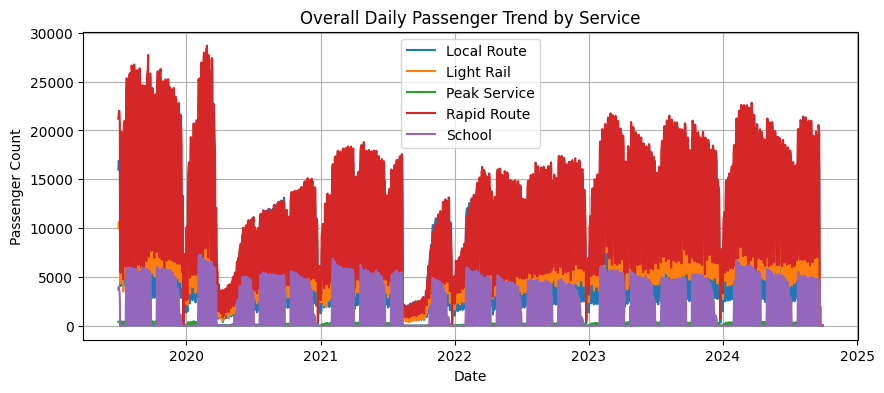

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for col in ['Local Route','Light Rail','Peak Service','Rapid Route','School']:
    plt.plot(df_clean['Date'], df_clean[col], label=col)
plt.legend()
plt.title("Overall Daily Passenger Trend by Service")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.grid(True)
plt.show()

This plot shows how daily passenger demand for each transport service changes over time, clearly highlighting that Rapid Route carries the highest load, School service has strong stop–start patterns on weekends, and major system-wide drops occur during disruption periods.

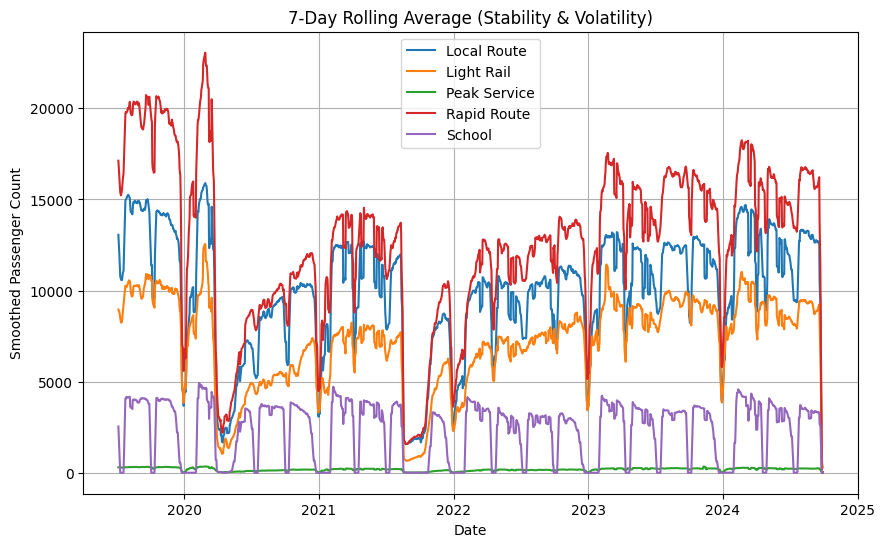

In [26]:
rolling_df = df_clean.copy()
for col in ['Local Route','Light Rail','Peak Service','Rapid Route','School']:
    rolling_df[col] = rolling_df[col].rolling(7).mean()
plt.figure(figsize=(10,6))
for col in ['Local Route','Light Rail','Peak Service','Rapid Route','School']:
    plt.plot(rolling_df['Date'], rolling_df[col], label=col)
plt.legend()
plt.title("7-Day Rolling Average (Stability & Volatility)")
plt.xlabel("Date")
plt.ylabel("Smoothed Passenger Count")
plt.grid(True)
plt.show()


Light Rail  → Smooth and steady → Most stable service

Rapid Route → Large ups and downs → Highly volatile

Local Route → Moderate fluctuations → Medium stability

Peak Service → Always very low → Negligible contribution

School → Repeated sharp drops → Strongly dependent on weekdays

In [16]:
df_clean['DayOfWeek'] = df_clean['Date'].dt.day_name()

weekly_pattern = df_clean.groupby('DayOfWeek')[['Local Route','Light Rail',
                                                 'Peak Service','Rapid Route','School']].mean()
weekly_pattern


,Local Route,Light Rail,Peak Service,Rapid Route,School
DayOfWeek,,,,,
Friday,12543.755474,8510.229927,202.854015,14942.156934,3125.795620
Monday,11444.678832,7541.551095,235.678832,13858.824818,3014.364964
Saturday,3271.156934,5000.978102,0.000000,6640.737226,0.145985
Sunday,2191.868613,3588.069343,0.000000,5053.364964,0.072993
Thursday,13166.708029,8515.218978,255.058394,15740.025547,3369.963504
Tuesday,13243.072993,8591.718978,281.729927,15949.737226,3454.277372
Wednesday,13378.525547,8620.357664,281.748175,15995.645985,3504.244526


1)Wednesday is busier than Monday, especially for Rapid Route and School.

2)On an average Monday, about 13,858 people use Rapid Route, and about 3,014 students use School transport.

In [17]:
service_totals = df_clean[['Local Route','Light Rail','Peak Service',
                           'Rapid Route','School']].mean()
service_percentage = (service_totals / service_totals.sum()) * 100
service_percentage


,0
Local Route,30.703047
Light Rail,22.334779
Peak Service,0.557423
Rapid Route,39.101949
School,7.302802


KEY INSIGHTS :
1)Rapid Route is the primary load carrier, accounting for 39.1% of total daily demand with an average of 12,597 passengers/day, making it the most critical service in the network.

2)Peak Service has extremely low usage but very high variability — average is only 180 passengers/day, yet the standard deviation is 156, indicating high operational unpredictability despite low demand.

3)School transport is strictly weekday-driven — average demand is 3,400–3,500 on weekdays, but drops to ~0.15 on Saturday and ~0.07 on Sunday, showing near-total weekend inactivity.

4)Mid-week demand exceeds Monday demand — Rapid Route rises from 13,858 on Monday to ≈15,996 on Wednesday, proving that true congestion peaks mid-week, not at the start of the week.

5)Light Rail is the most stable high-volume service — with a mean of 7,195 passengers/day and lower relative volatility than Local and Rapid Routes, making it the most reliable baseline service for capacity planning.

FORECASTING:

In [19]:
train_df = df_clean.iloc[:-14]
valid_df = df_clean.iloc[-14:]

In [22]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

route_cols = ['Local Route','Light Rail','Peak Service',
              'Rapid Route','School']

forecast_horizon = 7
metrics = {}

for col in route_cols:

    temp = train_df[['Date', col]].rename(columns={'Date':'ds', col:'y'})
    temp['y'] = np.log(temp['y'].clip(lower=1))

    model = Prophet()
    model.fit(temp)

    future = model.make_future_dataframe(periods=14 + forecast_horizon, freq='D')
    forecast = model.predict(future)

    forecast['yhat'] = np.exp(forecast['yhat'])
    valid_pred = forecast.tail(14 + 7).head(14)['yhat'].values

    mae = mean_absolute_error(valid_df[col], valid_pred)
    rmse = np.sqrt(mean_squared_error(valid_df[col], valid_pred))

    metrics[col] = {'MAE': mae, 'RMSE': rmse}

metrics


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'Local Route': {'MAE': 6816.8639346654145,
  'RMSE': np.float64(8666.780685580346)},
 'Light Rail': {'MAE': 5228.750708664956,
  'RMSE': np.float64(6031.121510264458)},
 'Peak Service': {'MAE': 110.89027312266558,
  'RMSE': np.float64(148.19258855132892)},
 'Rapid Route': {'MAE': 9392.26890231437,
  'RMSE': np.float64(11128.29577610096)},
 'School': {'MAE': 1209.9954562031546, 'RMSE': np.float64(2199.3576375165853)}}

In [23]:
prophet_rmse = {k: v['RMSE'] for k, v in metrics.items()}

comparison_df = pd.DataFrame({
    'Baseline_RMSE': baseline_rmse,
    'Prophet_RMSE': prophet_rmse
})

comparison_df['Improvement_%'] = (
    (comparison_df['Baseline_RMSE'] - comparison_df['Prophet_RMSE']) /
     comparison_df['Baseline_RMSE']
) * 100

comparison_df


,Baseline_RMSE,Prophet_RMSE,Improvement_%
Local Route,10860.394031,8666.780686,20.198285
Light Rail,7165.881353,6031.121510,15.835594
Peak Service,211.455452,148.192589,29.917821
Rapid Route,13438.169220,11128.295776,17.188900
School,2884.211508,2199.357638,23.744925


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


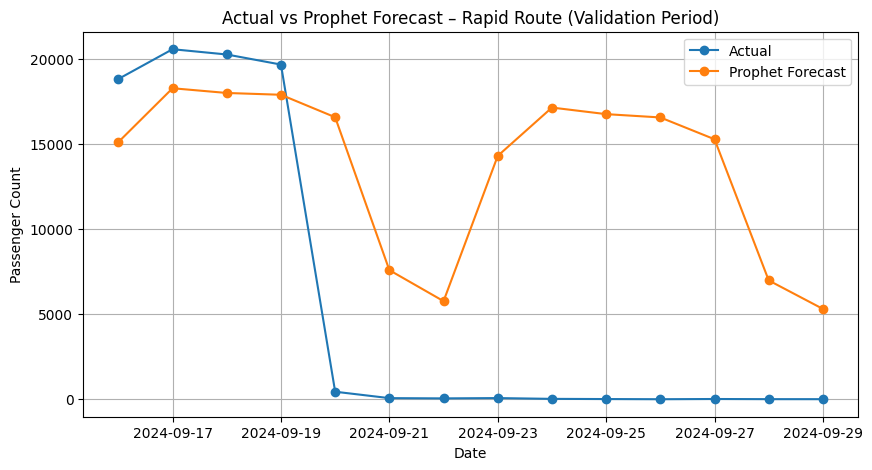

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# ========== Train Prophet for Rapid Route ==========
col = 'Rapid Route'

temp = train_df[['Date', col]].rename(columns={'Date':'ds', col:'y'})
temp['y'] = np.log(temp['y'].clip(lower=1))

model = Prophet()
model.fit(temp)

future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)

forecast['yhat'] = np.exp(forecast['yhat'])

actual = valid_df[['Date', col]].reset_index(drop=True)
predicted = forecast.tail(14)[['ds', 'yhat']].reset_index(drop=True)

compare_df = pd.DataFrame({
    'Date': actual['Date'],
    'Actual': actual[col],
    'Prophet_Predicted': predicted['yhat']
})

plt.figure(figsize=(10,5))
plt.plot(compare_df['Date'], compare_df['Actual'], label='Actual', marker='o')
plt.plot(compare_df['Date'], compare_df['Prophet_Predicted'], label='Prophet Forecast', marker='o')

plt.title("Actual vs Prophet Forecast – Rapid Route (Validation Period)")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.grid(True)
plt.show()


From the plot, we can see that the Prophet model is able to follow the general trend of the Rapid Route demand. However, when the actual passenger count suddenly drops to almost zero, the model does not fully capture this sudden change. This shows that Prophet works well for regular patterns, but unexpected events like holidays or service shutdowns can cause differences between actual and predicted values.
